# Рейтинг маршрутов
__Идея:__ помочь планировщикам выбрать самые выгодные маршруты за период.

__Цель:__ Оценка маршрутов (регионов, почтовых кодов) при помощи разных методик и составление рейтинга маршрутов.

__Задачи:__

1. Разработать методики оценки маршрутов (регионов, почтовых кодов).
2. Рассчитать рейтинги маршрутов (регионов, почтовых кодов) по различным методикам.
3. Проанализировать и сопоставить результаты полученных рейтингов.

__Методики:__

- Principal Component Analysis (PCA)
- Data Envelopment Analysis (DEA)

__Исходные данные:__
1. Маршрут (Route)
2. Регионы (Regions)
3. Почтовые коды (PostCodes)
4. Тип прицепа (TrailerType)
5. Тип груза (CargoWeight)
6. Вес груза (CargoType)
7. Пробег (Mileage)
8. Дни (Days)
9. Доход (Income)

## Импорт библиотек

In [1]:
# Libraries loading
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

#from sklearn.cross_validation import train_test_split
from sklearn import datasets
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler # Normalization MinMax
#from sklearn.preprocessing import StandardScaler # Normalization Std

from scipy.stats import stats, kstest, norm
import math

from sklearn.decomposition import PCA

#from pyDEA.core.utils import dea_utils
#from pyDEA import main_gui
#import pyDEA as dea
#import pyDEA
#import keras

## Форматирование, очистка и преобразование данных

### Загрузка данных

In [2]:
df = pd.read_csv('data.csv', encoding='cp1251')
df = df[['id', 'Route', 'Regions', 'PostCodes', 'TrailerType', 'CargoType', 'CargoWeight', 'DriversNumber', 'Days', 'Mileage',
        'Income']]# 
df.head()

D:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,1131,LV-BG,Baltics-Balkans / Turkey,LV42 - BG53,РЕФ,Стекловолокно,0.0,1,40.250000,2872.785,2150.0
1,141210,NO-ES,Norway (South)-Spain,NO60 - ES28,РЕФ,рыба (свежая),0.0,1,32.358333,3525.411,3657.0
2,138080,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,275.803,402.2
3,56313,LV-BG,Baltics-Balkans / Turkey,LV - BG,РЕФ,NaN,0.0,1,23.916667,2775.793,2150.0
4,47156,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.001,1400.0


### Форматирование данных

In [3]:
df['CargoWeight'] = pd.to_numeric(df['CargoWeight']).astype(np.float64)
df['Days'] = pd.to_numeric(df['Days']).astype(np.float64)
df['Mileage'] = pd.to_numeric(df['Mileage']).astype(np.float64)
df['Income'] = pd.to_numeric(df['Income']).astype(np.float64)

### Пропущенные значения 

In [4]:
# See the column data types and non-missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180069 entries, 0 to 180068
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             180069 non-null  int64  
 1   Route          180069 non-null  object 
 2   Regions        180069 non-null  object 
 3   PostCodes      180069 non-null  object 
 4   TrailerType    180041 non-null  object 
 5   CargoType      173940 non-null  object 
 6   CargoWeight    180039 non-null  float64
 7   DriversNumber  180069 non-null  object 
 8   Days           180069 non-null  float64
 9   Mileage        180069 non-null  float64
 10  Income         180069 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 15.1+ MB


## Выбросы

In [5]:
len(df)

180069

### Income

В колонке "Доход" есть записи с нулевым доходом или ниже, такие записи необходимо удалить. Затем убрать выбросы по квартилям.

#### Удаление записей с доходом 0 и ниже

In [6]:
df = df[df.Income>0]
len(df)

180034

In [7]:
df = df.reset_index()
df = df.iloc[:,df.columns!='index']
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,1131,LV-BG,Baltics-Balkans / Turkey,LV42 - BG53,РЕФ,Стекловолокно,0.0,1,40.250000,2872.785,2150.0
1,141210,NO-ES,Norway (South)-Spain,NO60 - ES28,РЕФ,рыба (свежая),0.0,1,32.358333,3525.411,3657.0
2,138080,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,275.803,402.2
3,56313,LV-BG,Baltics-Balkans / Turkey,LV - BG,РЕФ,NaN,0.0,1,23.916667,2775.793,2150.0
4,47156,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.001,1400.0


In [8]:
# Summary
df.Income.describe()

count    180034.000000
mean        865.492359
std         785.012130
min           0.010000
25%         375.900000
50%         555.840000
75%        1170.000000
max        7600.000000
Name: Income, dtype: float64

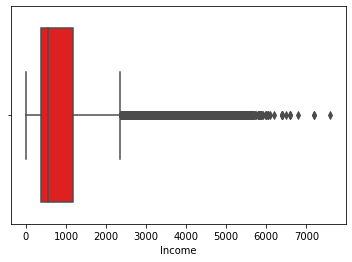

In [9]:
sns.boxplot(df.Income, color='red')

#### Удаление выбросов

In [10]:
len(df)

180034

In [11]:
first_quartile = df["Income"].describe()['25%']
third_quartile = df["Income"].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df = df[(df["Income"] > (first_quartile - 3 * iqr)) &
            (df["Income"] < (third_quartile + 3 * iqr))]

len(df)

176545

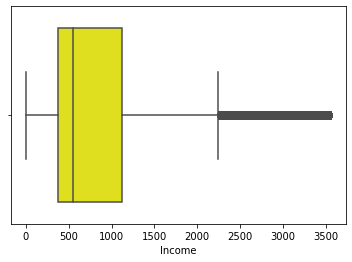

In [12]:
sns.boxplot(df.Income, color='yellow')

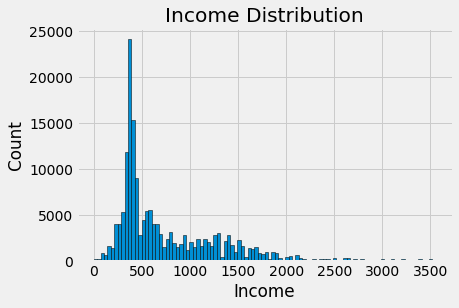

In [13]:
plt.style.use('fivethirtyeight')
plt.hist(df['Income'].dropna(), bins = 100, edgecolor = 'black');
plt.xlabel('Income'); 
plt.ylabel('Count'); plt.title('Income Distribution');

In [14]:
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,1131,LV-BG,Baltics-Balkans / Turkey,LV42 - BG53,РЕФ,Стекловолокно,0.0,1,40.250000,2872.785,2150.0
2,138080,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,275.803,402.2
3,56313,LV-BG,Baltics-Balkans / Turkey,LV - BG,РЕФ,NaN,0.0,1,23.916667,2775.793,2150.0
4,47156,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.001,1400.0
5,91500,LV-IT,Baltics-Italy,LVLV - IT12,РЕФ,торф,0.0,1,22.449306,2543.466,1400.0


In [15]:
df = df.reset_index()
df = df.iloc[:,df.columns!='index']
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,1131,LV-BG,Baltics-Balkans / Turkey,LV42 - BG53,РЕФ,Стекловолокно,0.0,1,40.250000,2872.785,2150.0
1,138080,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,275.803,402.2
2,56313,LV-BG,Baltics-Balkans / Turkey,LV - BG,РЕФ,NaN,0.0,1,23.916667,2775.793,2150.0
3,47156,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.001,1400.0
4,91500,LV-IT,Baltics-Italy,LVLV - IT12,РЕФ,торф,0.0,1,22.449306,2543.466,1400.0


### Mileage

В колонке "Пробег" записи с нулевыми и пропущенными значениями заменяем на среднее значение.
Затем убрать выбросы по квартилям.

#### Поиск записей с нулевым и незаполненным пробегом

In [16]:
len(df)

176545

In [17]:
# Filled values not equal 0 and not are null of 'Mileage' 
#df.shape[0]-
df.id[(round(df.Mileage)==0) | df.Mileage.isna()].count()

3111

In [18]:
df[(round(df.Mileage)==0) | df.Mileage.isna()]

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
9,149904,FR-LT,no data-no data,FR - LT,РЕФ,NaN,NaN,-,19.000000,0.000,3200.00
11,95606,DE-DE,CentralEurope-CentralEurope,DE63 - DE63,РЕФ,Почта DPD,0.0,1,18.000000,0.000,215.00
16,121911,FR-LV,no data-no data,FR - LV,РЕФ,NaN,NaN,-,15.000000,0.000,1200.00
27,87403,ES-LV,no data-no data,ES - LV,РЕФ,NaN,NaN,-,14.000000,0.000,3300.00
163,36095,IT-LV,no data-no data,IT - LV,РЕФ,NaN,NaN,-,10.000000,0.000,1300.00
...,...,...,...,...,...,...,...,...,...,...,...
176540,78377,DE-DE,BENELUX-BENELUX,DE41 - DE44,ТЕНТ,Почта DPD,0.0,2,0.020139,0.192,366.71
176541,55487,CZ-CZ,CentralEurope-CentralEurope,CZ10 - CZ25,ТЕНТ,Почта DPD,0.0,2,0.020139,0.014,340.72
176542,26160,GB-DE,UK-Denmark,GBRM - DE34,РЕФ,Почта DPD,0.0,1,0.020139,0.005,400.00
176543,100881,FR-FR,BENELUX-BENELUX,FR59 - FR59,ТЕНТ,Почта DPD,0.0,2,0.020139,0.004,373.37


In [19]:
# Summary
df.Mileage.describe()

count    176545.000000
mean        657.073531
std         621.093622
min           0.000000
25%         241.001000
50%         496.034000
75%         859.655000
max       11760.441000
Name: Mileage, dtype: float64

In [20]:
# the most common value of 'Mileage'
#mean_Mileage=df.Mileage[df.Days.value_counts()].mean()
mean_Mileage = (df.Mileage[df.Mileage>0]/np.ceil(df.Days)).mean()
mean_Mileage

371.697464278891

#### Замена записей с нулевым пробегом на средний

In [21]:
# Replace 0 values with np.NaN
df['Mileage'] = round(df['Mileage']).replace(0, np.NaN)
df.Mileage[round(df.Mileage)==0].count()

0

In [22]:
df[(round(df.Mileage)==0) | df.Mileage.isna()]

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
9,149904,FR-LT,no data-no data,FR - LT,РЕФ,NaN,NaN,-,19.000000,NaN,3200.00
11,95606,DE-DE,CentralEurope-CentralEurope,DE63 - DE63,РЕФ,Почта DPD,0.0,1,18.000000,NaN,215.00
16,121911,FR-LV,no data-no data,FR - LV,РЕФ,NaN,NaN,-,15.000000,NaN,1200.00
27,87403,ES-LV,no data-no data,ES - LV,РЕФ,NaN,NaN,-,14.000000,NaN,3300.00
163,36095,IT-LV,no data-no data,IT - LV,РЕФ,NaN,NaN,-,10.000000,NaN,1300.00
...,...,...,...,...,...,...,...,...,...,...,...
176540,78377,DE-DE,BENELUX-BENELUX,DE41 - DE44,ТЕНТ,Почта DPD,0.0,2,0.020139,NaN,366.71
176541,55487,CZ-CZ,CentralEurope-CentralEurope,CZ10 - CZ25,ТЕНТ,Почта DPD,0.0,2,0.020139,NaN,340.72
176542,26160,GB-DE,UK-Denmark,GBRM - DE34,РЕФ,Почта DPD,0.0,1,0.020139,NaN,400.00
176543,100881,FR-FR,BENELUX-BENELUX,FR59 - FR59,ТЕНТ,Почта DPD,0.0,2,0.020139,NaN,373.37


In [23]:
df.Mileage=df.Mileage.fillna(mean_Mileage)
df.Mileage.head()

0    2873.0
1     276.0
2    2776.0
3    2500.0
4    2543.0
Name: Mileage, dtype: float64

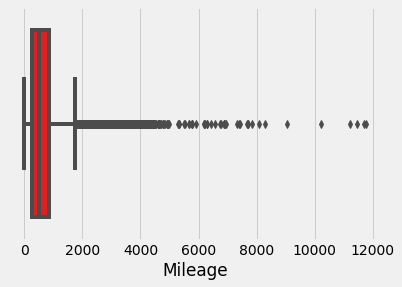

In [24]:
sns.boxplot(df.Mileage, color='red')

#### Удаление выбросов

In [25]:
len(df)

176545

In [26]:
first_quartile = df["Mileage"].describe()['25%']
third_quartile = df["Mileage"].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df = df[(df["Mileage"] > (first_quartile - 3 * iqr)) &
            (df["Mileage"] < (third_quartile + 3 * iqr))]

len(df)

173877

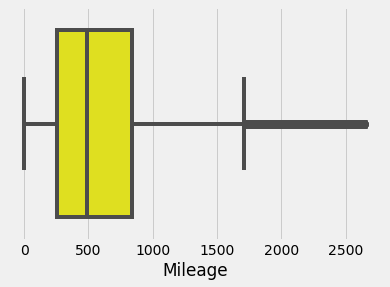

In [27]:
sns.boxplot(df.Mileage, color='yellow')

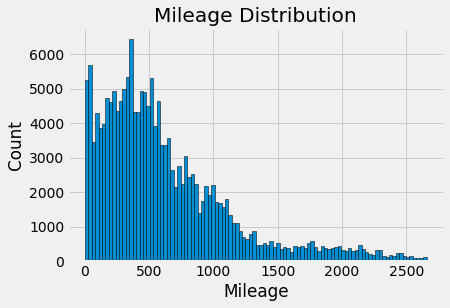

In [28]:
#figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.hist(df['Mileage'].dropna(), bins = 100, edgecolor = 'black');
plt.xlabel('Mileage'); 
plt.ylabel('Count'); plt.title('Mileage Distribution');

Text(0, 0.5, 'Income')

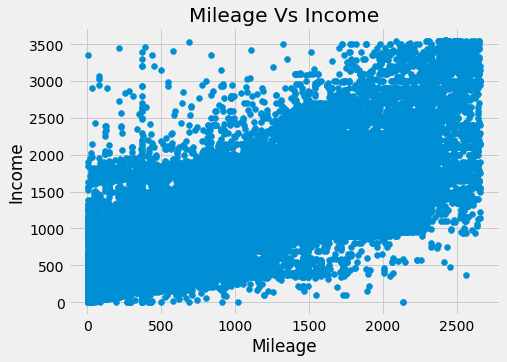

In [29]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(x = df['Mileage'], y = df['Income'], marker = 'o')
axes.set_title('Mileage Vs Income')
axes.set_xlabel('Mileage')
axes.set_ylabel('Income')

In [30]:
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
1,138080,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,276.0,402.2
3,47156,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.0,1400.0
4,91500,LV-IT,Baltics-Italy,LVLV - IT12,РЕФ,торф,0.0,1,22.449306,2543.0,1400.0
5,16896,LV-IT,Baltics-Italy,LVLV - IT26,РЕФ,торф,0.0,1,20.319444,2286.0,1450.0
6,156014,LV-IT,Baltics-Italy,LVLV - IT26,РЕФ,торф,0.0,1,19.925000,2277.0,1400.0


In [31]:
df = df.reset_index()
df = df.iloc[:,df.columns!='index']
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,138080,DE-DE,BENELUX-BENELUX,DE47 - DE30,ТЕНТ,Почта DPD,0.0,2,30.020833,276.0,402.2
1,47156,LV-IT,Baltics-Italy,LVLV - IT17,РЕФ,торф,0.0,1,23.134028,2500.0,1400.0
2,91500,LV-IT,Baltics-Italy,LVLV - IT12,РЕФ,торф,0.0,1,22.449306,2543.0,1400.0
3,16896,LV-IT,Baltics-Italy,LVLV - IT26,РЕФ,торф,0.0,1,20.319444,2286.0,1450.0
4,156014,LV-IT,Baltics-Italy,LVLV - IT26,РЕФ,торф,0.0,1,19.925000,2277.0,1400.0


### Days

В колонке "Дни" проверяем записи на наличие нулевых и пропущенных значениями. 
Затем убираем выбросы по квартилям.

#### Поиск записей с нулевыми и незаполненными днями

In [32]:
len(df)

173877

In [33]:
# Filled values not equal 0 and not are null of 'Days' 
#df.shape[0]-
df.id[(df.Days==0) | df.Days.isna()].count()

0

In [34]:
# Summary
df.Days.describe()

count    173877.000000
mean          1.183251
std           1.191297
min           0.020139
25%           0.340278
50%           0.833333
75%           1.701389
max          30.020833
Name: Days, dtype: float64

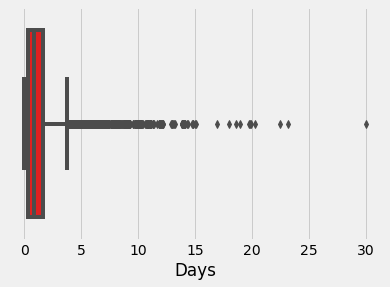

In [35]:
sns.boxplot(df.Days, color='red')

#### Удаление выбросов

In [36]:
len(df)

173877

In [37]:
first_quartile = df["Days"].describe()['25%']
third_quartile = df["Days"].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
df = df[(df["Days"] > (first_quartile - 3 * iqr)) &
            (df["Days"] < (third_quartile + 3 * iqr))]

len(df)

172772

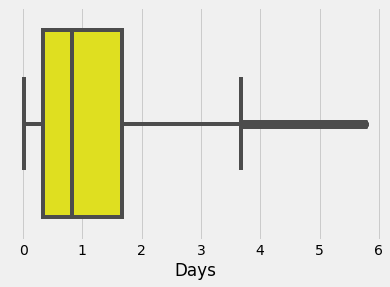

In [38]:
sns.boxplot(df.Days, color='yellow')

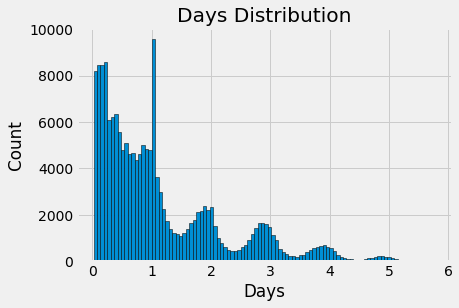

In [39]:
#figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.hist(df['Days'].dropna(), bins = 100, edgecolor = 'black');
plt.xlabel('Days'); 
plt.ylabel('Count'); plt.title('Days Distribution');

Text(0, 0.5, 'Income')

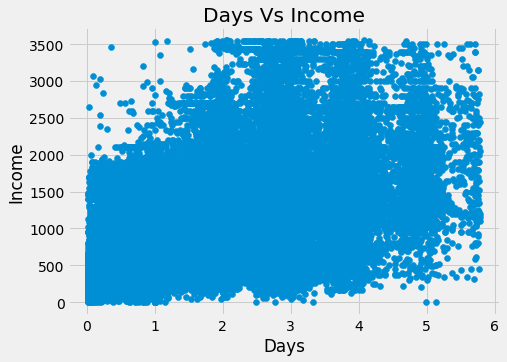

In [40]:
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(x = df['Days'], y = df['Income'], marker = 'o')
axes.set_title('Days Vs Income')
axes.set_xlabel('Days')
axes.set_ylabel('Income')

In [41]:
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
1105,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,РЕФ,молочные продукты,0.0,1,5.783333,2121.0,2450.00
1106,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,ТЕНТ,Паллеты,0.0,1,5.782662,1925.0,2056.54
1107,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,РЕФ,Древесина,0.0,1,5.781944,2100.0,1100.00
1108,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,РЕФ,шоколад (темп),0.0,1,5.780556,1243.0,1200.00
1109,95808,LV-IT,Baltics-Italy,LVLV - IT48,РЕФ,мука,0.0,1,5.779861,2215.0,1150.00


In [42]:
df = df.reset_index()
df = df.iloc[:,df.columns!='index']
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,CargoWeight,DriversNumber,Days,Mileage,Income
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,РЕФ,молочные продукты,0.0,1,5.783333,2121.0,2450.00
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,ТЕНТ,Паллеты,0.0,1,5.782662,1925.0,2056.54
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,РЕФ,Древесина,0.0,1,5.781944,2100.0,1100.00
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,РЕФ,шоколад (темп),0.0,1,5.780556,1243.0,1200.00
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,РЕФ,мука,0.0,1,5.779861,2215.0,1150.00


## Route

В колонке "Маршруты" могут содержаться неполные записи (только с одной страной - отправления или прибытия), такие записи необходимо удалить.

In [43]:
len(df)

172772

#### Поиск записей с не полностью заполненным маршрутом

In [44]:
# Empty values or null of 'Route' 
#df.shape[0]-
df.Route[(df.Route=='-') | (df.Route.isna())].count()

0

In [45]:
# Find rows with not fully filled routes (only one of countries)
remove_index_routes = []
df['Route'][1].split('-')
for i in range(len(df.Route)):
    if(df['Route'][i].split('-')[0]=='' or df['Route'][i].split('-')[1]==''):
        remove_index_routes.append(i)
        df=df.drop(i)
print(remove_index_routes) 

[]


In [46]:
len(df)

172772

In [47]:
# Summary
df.Route.describe()

count     172772
unique       509
top        DE-DE
freq       30442
Name: Route, dtype: object

## CargoWeight

В колонке "Вес груза" необходимо проверить количество нулевых и незаполненных значений. 

#### Поиск записей с нулевыми и незаполненными весами грузов

In [48]:
len(df)

172772

In [49]:
# Filled values not equal 0 and not are null of 'CargoWeight' 
#df.shape[0]-
df.id[(df.CargoWeight==0) | (df.CargoWeight.isna())].count()

166898

Т.к. очень мало заполненных значений, удаляем колонку CargoWeight.

In [50]:
# Remove column 'CargoWeight' because only 6000 rows not are null or 0
df = df.iloc[:,df.columns!='CargoWeight']
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,РЕФ,молочные продукты,1,5.783333,2121.0,2450.00
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,ТЕНТ,Паллеты,1,5.782662,1925.0,2056.54
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,РЕФ,Древесина,1,5.781944,2100.0,1100.00
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,РЕФ,шоколад (темп),1,5.780556,1243.0,1200.00
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,РЕФ,мука,1,5.779861,2215.0,1150.00


## CargoType

В колонке "Тип груза" необходимо проверить количество нулевых и незаполненных значений. Заменить эти значения на самое часто встречающееся.

#### Поиск записей с нулевым и незаполненным типом грузов

In [51]:
len(df)

172772

In [52]:
# Filled values not equal 0 and not are null of 'CargoType' 
#df.shape[0]-
df.id[(df.CargoType==0) | (df.CargoType.isna())].count()

5970

#### Замена записей с незаполненным типом груза на самый часто встречающийся

In [53]:
# Summary
df.CargoType.describe()

count        166802
unique          185
top       Почта DPD
freq          69687
Name: CargoType, dtype: object

In [54]:
# the most common value of 'CargoType'
#max_count_CargoType = df.CargoType[df.CargoType.value_counts().sum()]
max_count_CargoType = df.CargoType.describe().top
max_count_CargoType

'Почта DPD'

In [55]:
df.CargoType = df.CargoType.fillna(max_count_CargoType)
df.CargoType

0         молочные продукты
1                   Паллеты
2                 Древесина
3            шоколад (темп)
4                      мука
                ...        
172767            Почта DPD
172768            Почта DPD
172769            Почта DPD
172770            Почта DPD
172771            Почта DPD
Name: CargoType, Length: 172772, dtype: object

#### Преобразование колонки 'CargoType' в категориальную переменную

In [56]:
# Check how many categories in 'CargoType'
pd.get_dummies(df.CargoType).shape

(172772, 185)

In [57]:
#df = df.join(df_CargoType)
#df.head()

In [58]:
#df = df.drop(columns=['CargoType'])
#df.head()

## TrailerType

В колонке "Тип прицепа" проверяем наличие незаполненных записей. Заменяем на самое часто встречающееся в случае пропусков.
Далее преобразовываем переменную в фиктивные, разбив на количество уникальных значений данной переменной.

#### Поиск записей с нулевым и незаполненным типом прицепов

In [59]:
len(df)

172772

In [60]:
# Filled values not equal 0 and not are null of 'TrailerType' 
#df.shape[0]-
df.id[(df.TrailerType==0) | (df.TrailerType.isna())].count()

23

#### Замена записей с незаполненным типом прицепа на самый часто встречающийся

In [61]:
# Summary
df.TrailerType.describe()

count     172749
unique         2
top          РЕФ
freq      104431
Name: TrailerType, dtype: object

In [62]:
# the most common value of 'TrailerType'
#max_count_TrailerType = df.TrailerType[df.TrailerType.value_counts().sum()]
max_count_TrailerType = df.TrailerType.describe().top
max_count_TrailerType

'РЕФ'

In [63]:
df.TrailerType = df.TrailerType.fillna(max_count_TrailerType)
df.TrailerType

0          РЕФ
1         ТЕНТ
2          РЕФ
3          РЕФ
4          РЕФ
          ... 
172767    ТЕНТ
172768    ТЕНТ
172769     РЕФ
172770    ТЕНТ
172771    ТЕНТ
Name: TrailerType, Length: 172772, dtype: object

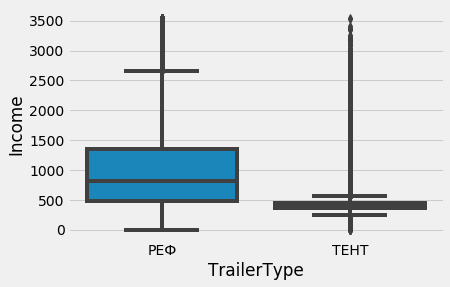

In [64]:
# Income by CargoType
sns.boxplot(x = 'TrailerType', y='Income', data=df)

#### График плотности категориальной переменной (TrailerType)

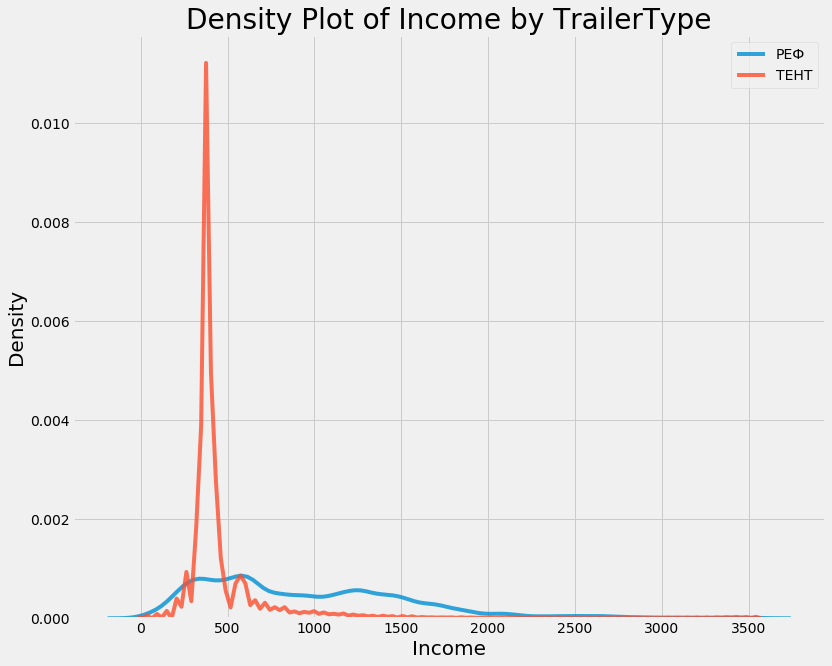

In [65]:
# Create a list of buildings with more than 100 measurements
types = df.dropna(subset=['Income'])
types = types['TrailerType'].value_counts()
types = list(types[types.values > 100].index)

# Plot of distribution of scores for building categories
figsize(12, 10)

# Plot each building
for b_type in types:
    # Select the building type
    subset = df[df['TrailerType'] == b_type]
    
    # Density plot of Energy Star Scores
    sns.kdeplot(subset['Income'].dropna(),
               label = b_type, shade = False, alpha = 0.8);
    
# label the plot
plt.xlabel('Income', size = 20); plt.ylabel('Density', size = 20); 
plt.title('Density Plot of Income by TrailerType', size = 28);

#### Преобразование колонки 'TrailerType' в категориальную переменную

In [66]:
# Check how many categories in 'TrailerType'
pd.get_dummies(df.TrailerType).shape

(172772, 2)

In [67]:
df_trailerType = pd.get_dummies(df.TrailerType)
df_trailerType.head()

,РЕФ,ТЕНТ
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0


In [68]:
df = df.join(df_trailerType)
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,РЕФ,ТЕНТ
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,РЕФ,молочные продукты,1,5.783333,2121.0,2450.00,1,0
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,ТЕНТ,Паллеты,1,5.782662,1925.0,2056.54,0,1
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,РЕФ,Древесина,1,5.781944,2100.0,1100.00,1,0
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,РЕФ,шоколад (темп),1,5.780556,1243.0,1200.00,1,0
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,РЕФ,мука,1,5.779861,2215.0,1150.00,1,0


#### Преобразование текстовых значений в числовые для колонки 'TrailerType' 

In [69]:
TrailerType_unique = {'РЕФ': 1, 'ТЕНТ': 2, 'КОНТЕЙНЕР': 3}

df['TrailerType'] = df['TrailerType'].apply(TrailerType_unique.get)
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,РЕФ,ТЕНТ
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,5.783333,2121.0,2450.00,1,0
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,5.782662,1925.0,2056.54,0,1
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,5.781944,2100.0,1100.00,1,0
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,5.780556,1243.0,1200.00,1,0
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,5.779861,2215.0,1150.00,1,0


In [70]:
#df = df.drop(columns=['TrailerType'])
#df.head()

In [71]:
df = df.rename(columns={"КОНТЕЙНЕР": "Container", "РЕФ": "Ref", "ТЕНТ": "Canvas"})
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,5.783333,2121.0,2450.00,1,0
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,5.782662,1925.0,2056.54,0,1
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,5.781944,2100.0,1100.00,1,0
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,5.780556,1243.0,1200.00,1,0
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,5.779861,2215.0,1150.00,1,0


## Income_per_Km

Создание дополнительной переменной "Доход на километр". 

In [72]:
len(df)

172772

In [73]:
df['Income_per_Km'] = df.Income/df.Mileage
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,5.783333,2121.0,2450.00,1,0,1.155116
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,5.782662,1925.0,2056.54,0,1,1.068332
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,5.781944,2100.0,1100.00,1,0,0.523810
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,5.780556,1243.0,1200.00,1,0,0.965406
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,5.779861,2215.0,1150.00,1,0,0.519187


In [74]:
# Summary
df.Income_per_Km.describe()

count    172772.000000
mean          4.212753
std          26.984633
min           0.000005
25%           0.985732
50%           1.274839
75%           1.822033
max        1904.670000
Name: Income_per_Km, dtype: float64

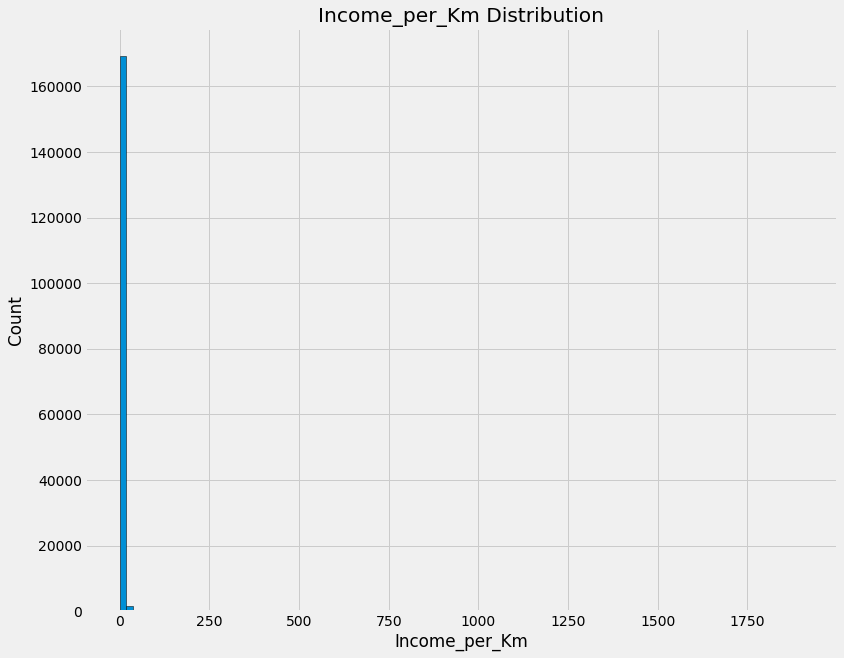

In [75]:
#figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.hist(df['Income_per_Km'].dropna(), bins = 100, edgecolor = 'black');
plt.xlabel('Income_per_Km'); 
plt.ylabel('Count'); plt.title('Income_per_Km Distribution');

## Income_per_Day

Создание дополнительной переменной "Доход на день".

In [76]:
len(df)

172772

In [77]:
df['Income_per_Day'] = df.Income/df.Days
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km,Income_per_Day
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,5.783333,2121.0,2450.00,1,0,1.155116,423.631124
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,5.782662,1925.0,2056.54,0,1,1.068332,355.638975
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,5.781944,2100.0,1100.00,1,0,0.523810,190.247418
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,5.780556,1243.0,1200.00,1,0,0.965406,207.592504
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,5.779861,2215.0,1150.00,1,0,0.519187,198.966719


In [78]:
# Summary
df.Income_per_Day.describe()

count    172772.000000
mean       1500.270185
std        2541.398156
min           0.001946
25%         490.146649
50%         802.973978
75%        1494.682105
max       70452.000000
Name: Income_per_Day, dtype: float64

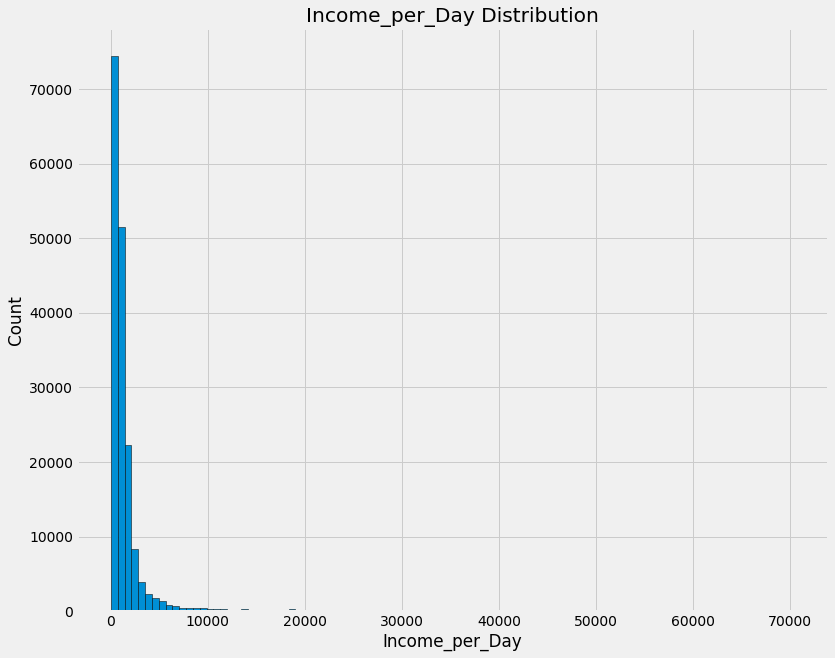

In [79]:
#figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.hist(df['Income_per_Day'].dropna(), bins = 100, edgecolor = 'black');
plt.xlabel('Income_per_Day'); 
plt.ylabel('Count'); plt.title('Income_per_Day Distribution');

## Проверка статистики после преобразования данных

Проверка остались ли незаполненные значения переменных

In [80]:
# Check null values in columns
df.isnull().sum()

id                0
Route             0
Regions           0
PostCodes         0
TrailerType       0
CargoType         0
DriversNumber     0
Days              0
Mileage           0
Income            0
Ref               0
Canvas            0
Income_per_Km     0
Income_per_Day    0
dtype: int64

In [81]:
# Summary after data transformation
df[['Days', 'Income', 'Mileage', 'Income_per_Km', 'Income_per_Day']].describe()

,Days,Income,Mileage,Income_per_Km,Income_per_Day
count,172772.000000,172772.000000,172772.000000,172772.000000,172772.000000
mean,1.144043,760.643452,614.200347,4.212753,1500.270185
std,1.075162,554.951489,505.737684,26.984633,2541.398156
min,0.020139,0.010000,1.000000,0.000005,0.001946
25%,0.336866,374.650000,254.000000,0.985732,490.146649
50%,0.829861,531.635000,485.000000,1.274839,802.973978
75%,1.671528,1088.590000,829.000000,1.822033,1494.682105
max,5.783333,3552.020000,2659.000000,1904.670000,70452.000000


In [82]:
df_sc = df.copy()

## Проверка данных на нормальное распределение
Проверка данных на линейность

#### Income

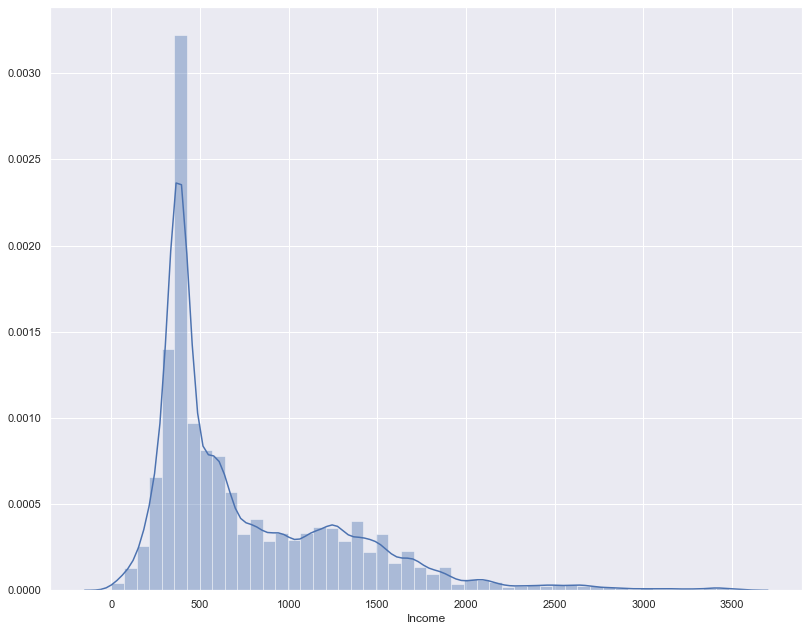

In [83]:
sns.set()
sns.distplot(df_sc['Income'])

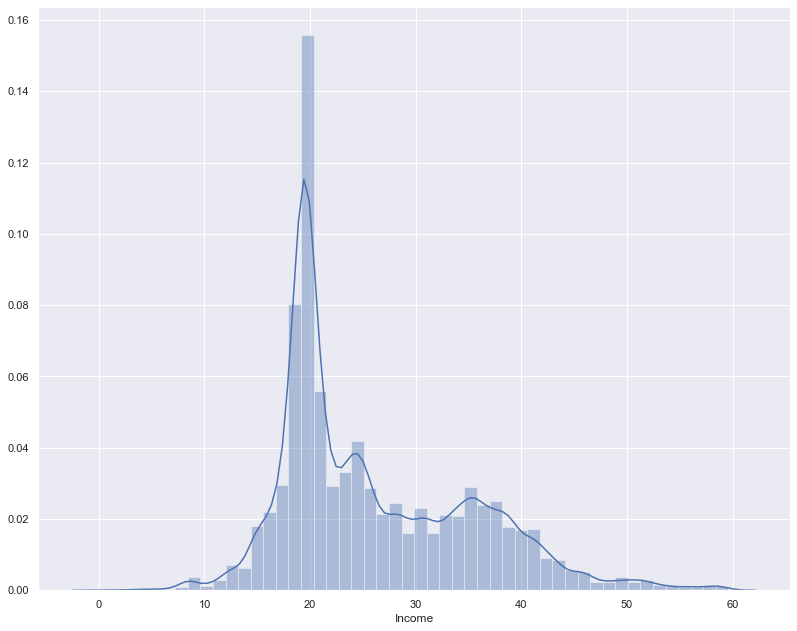

In [84]:
# Sqrt 'Income' 
sns.set()
sns.distplot(np.sqrt(df_sc.Income))

#### Mileage

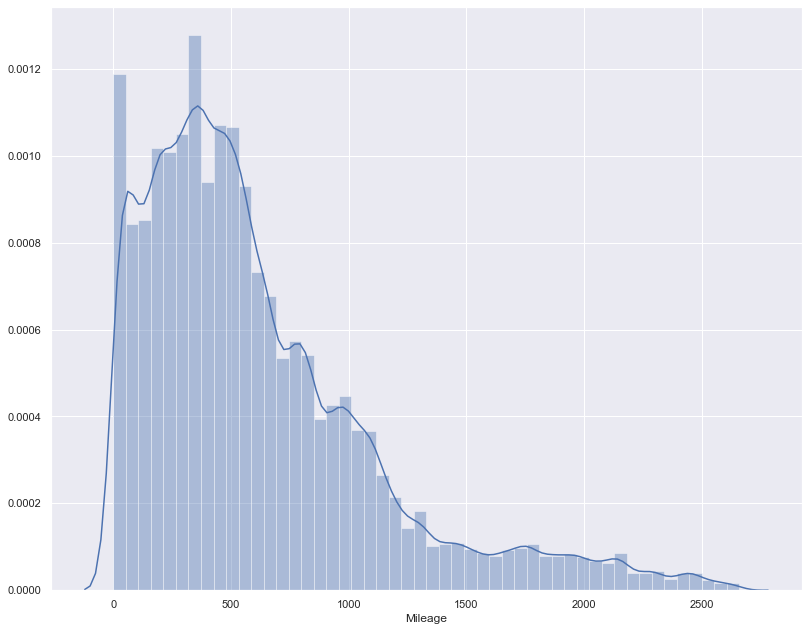

In [85]:
sns.set()
sns.distplot(df_sc['Mileage'])

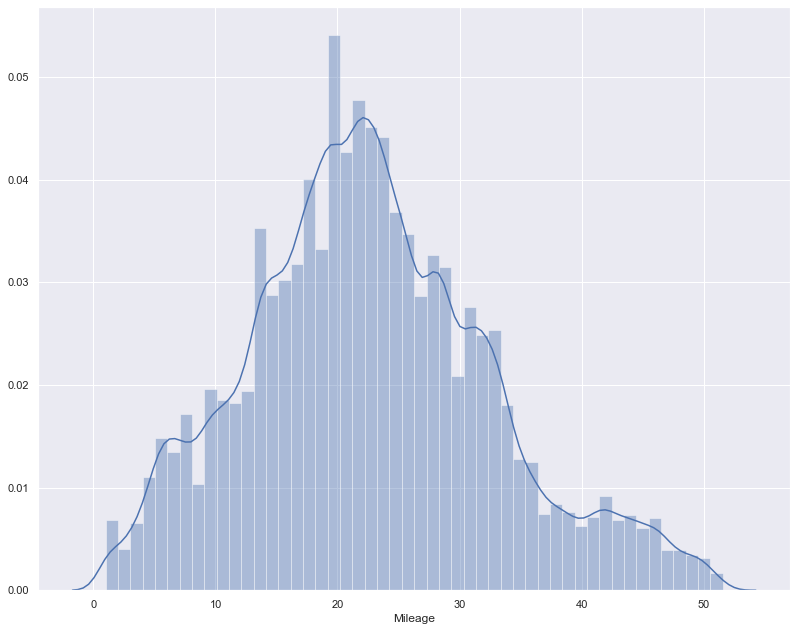

In [86]:
# Sqrt 'Mileage' 
sns.set()
sns.distplot(np.sqrt(df_sc.Mileage))

#### Days

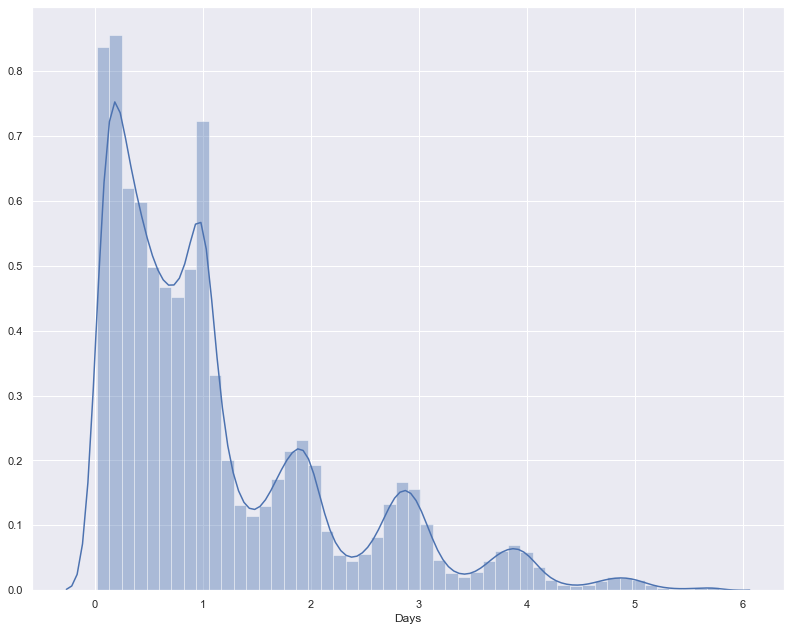

In [87]:
sns.set()
sns.distplot(df_sc['Days'])

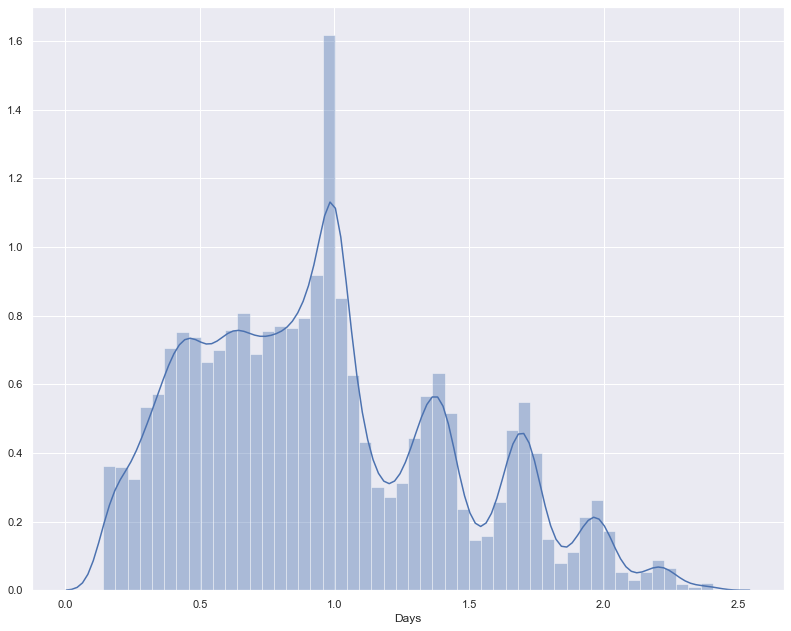

In [88]:
# Sqrt 'Days' 
sns.set()
sns.distplot(np.sqrt(df_sc.Days))

#### Income_per_Km

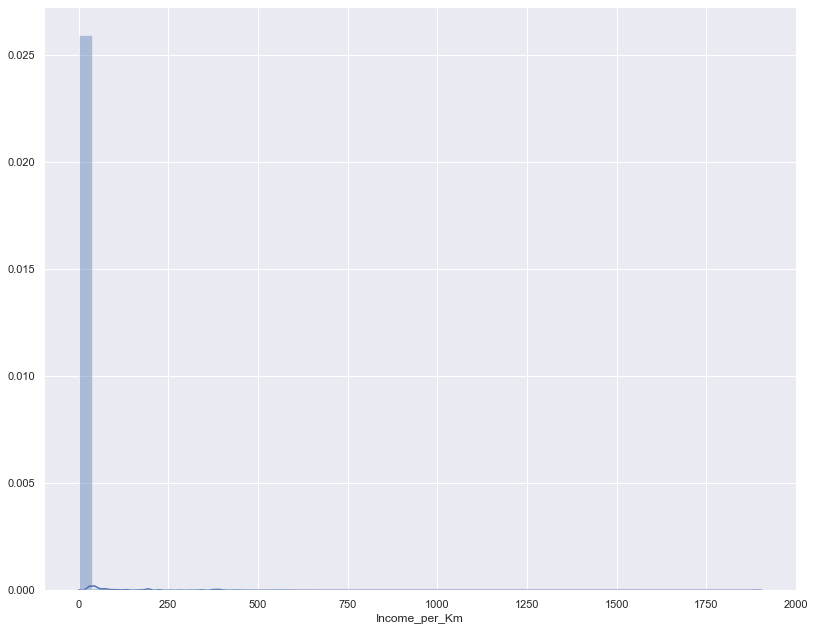

In [89]:
sns.set()
sns.distplot(df_sc['Income_per_Km'])

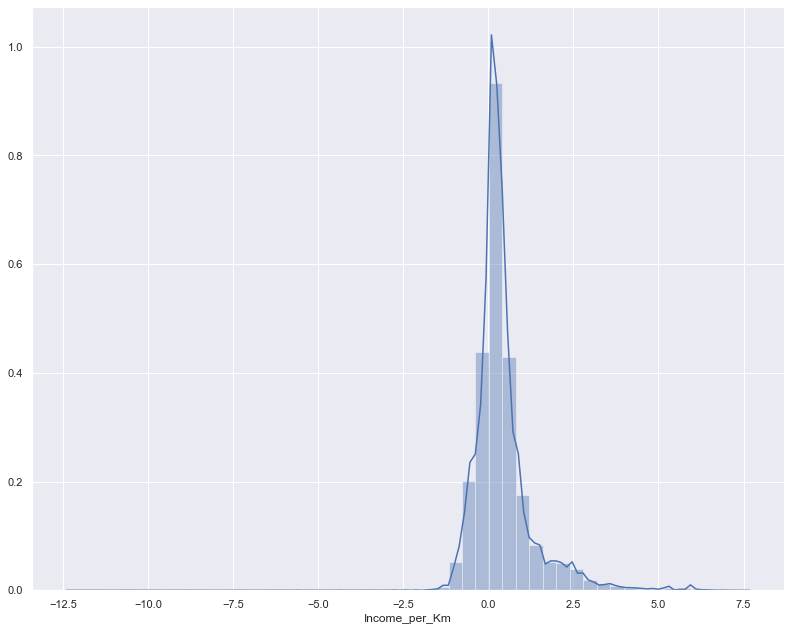

In [90]:
# Log 'Income_per_Km'
sns.set()
sns.distplot(np.log(df_sc.Income_per_Km))

#### Income_per_Day

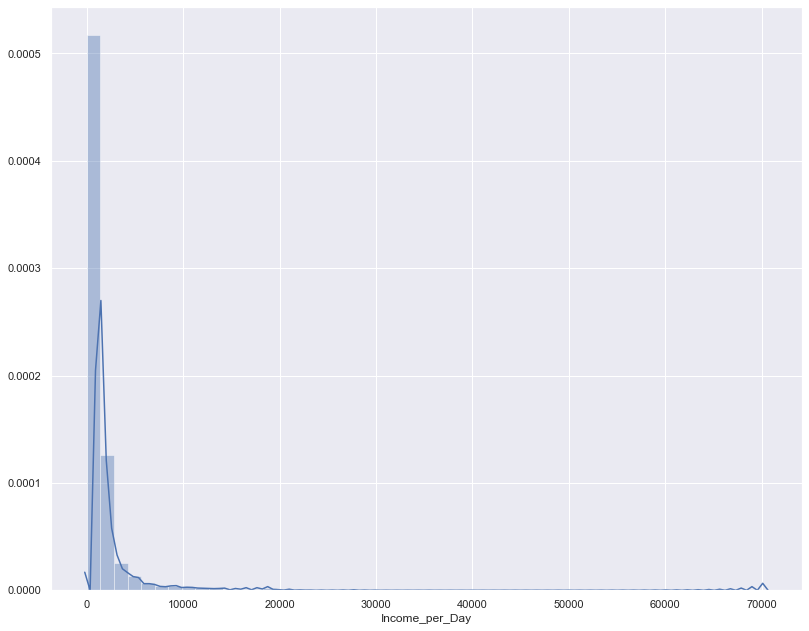

In [91]:
sns.set()
sns.distplot(df_sc['Income_per_Day'])

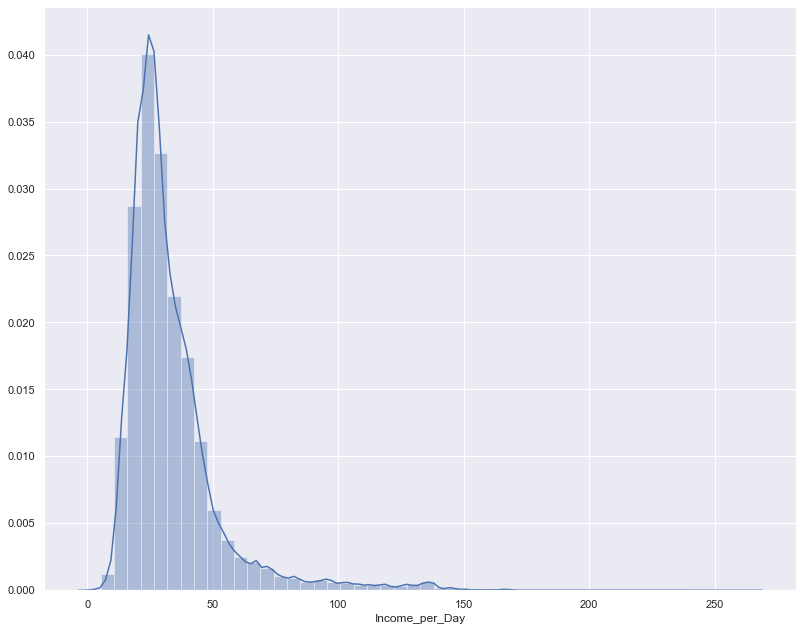

In [92]:
# Sqrt 'Income_per_Day' 
sns.set()
sns.distplot(np.sqrt(df_sc.Income_per_Day))

## Преобразование данных

Преобразование данных в соответствии с проведенным выше анализом.

In [93]:
# Transform 'Income' with Sqrt 
df_sc['Income'] = np.sqrt(df_sc.Income)
df_sc.Income.head()

0    49.497475
1    45.349090
2    33.166248
3    34.641016
4    33.911650
Name: Income, dtype: float64

In [94]:
# Transform 'Days' with Sqrt 
df_sc['Days'] = np.sqrt(df_sc.Days)
df_sc.Days.head()

0    2.404856
1    2.404717
2    2.404567
3    2.404279
4    2.404134
Name: Days, dtype: float64

In [95]:
# Transform 'Mileage' with Sqrt 
df_sc['Mileage'] = np.sqrt(df_sc.Mileage)
df_sc.Mileage.head()

0    46.054316
1    43.874822
2    45.825757
3    35.256205
4    47.063787
Name: Mileage, dtype: float64

In [96]:
# Transform 'Income_per_Km' with Log 
df_sc['Income_per_Km'] = np.log(df_sc.Income_per_Km)
df_sc.Income_per_Km.head()

0    0.144200
1    0.066099
2   -0.646627
3   -0.035206
4   -0.655490
Name: Income_per_Km, dtype: float64

In [97]:
# Transform 'Income_per_Day' with Sqrt 
df_sc['Income_per_Day'] = np.sqrt(df_sc.Income_per_Day)
df_sc.Income_per_Day.head() 

0    20.582301
1    18.858393
2    13.793021
3    14.408071
4    14.105556
Name: Income_per_Day, dtype: float64

In [98]:
df_sc.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km,Income_per_Day
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,2.404856,46.054316,49.497475,1,0,0.144200,20.582301
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,2.404717,43.874822,45.349090,0,1,0.066099,18.858393
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,2.404567,45.825757,33.166248,1,0,-0.646627,13.793021
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,2.404279,35.256205,34.641016,1,0,-0.035206,14.408071
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,2.404134,47.063787,33.911650,1,0,-0.655490,14.105556


In [99]:
df_n = df_sc.copy()

### Нормирование данных

In [100]:
column_names_to_normalize = ['Days', 'Mileage', 'Income_per_Km', 'Income_per_Day', 'Income'] #'Income'
df_norm = df_n[column_names_to_normalize].values
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_norm)
df_temp = pd.DataFrame(df_scaled, columns=column_names_to_normalize, index = df_n.index)
df_norm = df_n
df_norm[column_names_to_normalize] = df_temp
df_norm.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km,Income_per_Day
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,1.000000,0.891009,0.830226,1,0,0.626308,0.077390
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,0.999938,0.847907,0.760504,0,1,0.622368,0.070895
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,0.999872,0.886489,0.555746,1,0,0.586415,0.051808
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,0.999745,0.677462,0.580533,1,0,0.617258,0.054125
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,0.999681,0.910973,0.568274,1,0,0.585968,0.052985


In [101]:
df.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km,Income_per_Day
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,5.783333,2121.0,2450.00,1,0,1.155116,423.631124
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,5.782662,1925.0,2056.54,0,1,1.068332,355.638975
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,5.781944,2100.0,1100.00,1,0,0.523810,190.247418
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,5.780556,1243.0,1200.00,1,0,0.965406,207.592504
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,5.779861,2215.0,1150.00,1,0,0.519187,198.966719


In [102]:
df_sc.head()

,id,Route,Regions,PostCodes,TrailerType,CargoType,DriversNumber,Days,Mileage,Income,Ref,Canvas,Income_per_Km,Income_per_Day
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,1,молочные продукты,1,2.404856,46.054316,49.497475,1,0,0.144200,20.582301
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,2,Паллеты,1,2.404717,43.874822,45.349090,0,1,0.066099,18.858393
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,1,Древесина,1,2.404567,45.825757,33.166248,1,0,-0.646627,13.793021
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,1,шоколад (темп),1,2.404279,35.256205,34.641016,1,0,-0.035206,14.408071
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,1,мука,1,2.404134,47.063787,33.911650,1,0,-0.655490,14.105556


### Датафреймы:

- __*df*__ - исходные данные
- __*df_sc*__ - преобразованные данные при помощи sqrt или log
- __*df_norm*__ - преобразованные данные при помощи sqrt или log + нормированные

### Корреляция данных

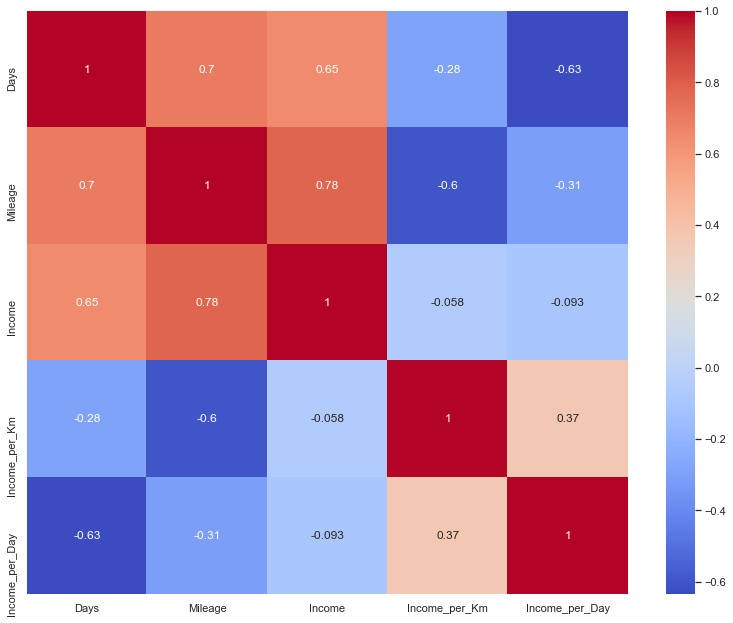

In [103]:
# Check variables correlation NORMALIZED DATA
#correlation = df.iloc[:,df.columns!='id'].corr()
correlation = df_norm[['Days', 'Mileage', 'Income', 'Income_per_Km', 'Income_per_Day']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [104]:
# Find all correlations with 'Income' and sort NORMALIZED DATA
correlations_df_NORM = df_norm.iloc[:,df_norm.columns!='id'].corr()['Income'].sort_values()
correlations_df_NORM

TrailerType      -0.442830
Canvas           -0.442830
Income_per_Day   -0.093412
Income_per_Km    -0.058264
Ref               0.442830
Days              0.645781
Mileage           0.777912
Income            1.000000
Name: Income, dtype: float64

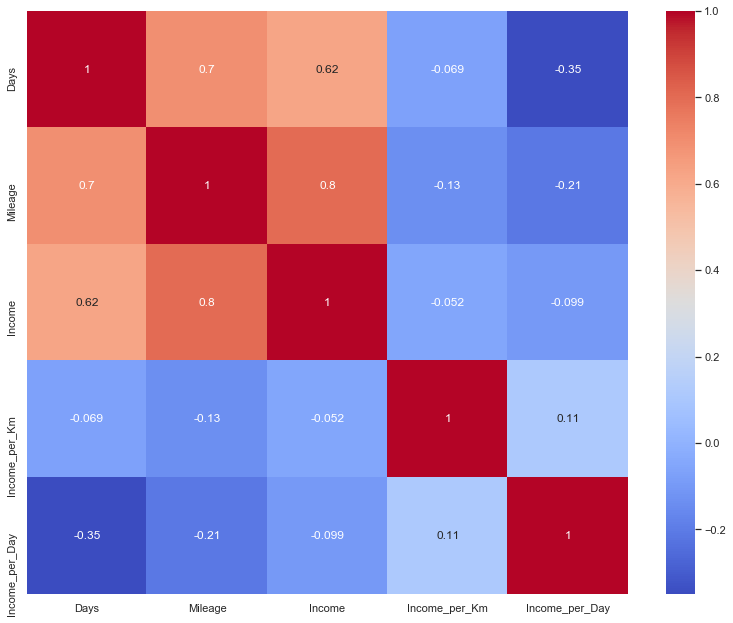

In [105]:
# Check variables correlation RAW DATA
#correlation = df.iloc[:,df.columns!='id'].corr()
correlation = df[['Days', 'Mileage', 'Income', 'Income_per_Km', 'Income_per_Day']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [106]:
# Find all correlations with 'Income' and sort RAW DATA
correlations_df_RAW = df.iloc[:,df.columns!='id'].corr()['Income'].sort_values()
correlations_df_RAW

TrailerType      -0.430344
Canvas           -0.430344
Income_per_Day   -0.098656
Income_per_Km    -0.051946
Ref               0.430344
Days              0.623143
Mileage           0.803989
Income            1.000000
Name: Income, dtype: float64

## Principal Component Analysis (PCA)

Для построения рейтинга при помощи PCA исользуются след. переменные:
    - Дни
    - Пробег
    - Доход на км
    - Доход на день
    - Доход

Сначала рассчитываются главные компоненты. Затем значения усредняются по маршруту (регионам, почтовым кодам), ранжируются.

In [107]:
pca = PCA(n_components=2)

In [108]:
columns_for_pca = df_norm[['Days','Mileage','Income_per_Km', 'Income_per_Day', 'Income']]

In [109]:
pca.fit(columns_for_pca)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [110]:
print(pca.components_)

[[ 0.65150422  0.60962393 -0.06045163 -0.11683834  0.43196679]
 [-0.66501882  0.47000692 -0.02901099  0.37939364  0.43824912]]


In [111]:
## The percentage of the explained variance 
pca.explained_variance_ratio_

array([0.77113625, 0.13862092])

In [112]:
X_pca = pca.transform(columns_for_pca)
print("original shape:   ", columns_for_pca.shape)
print("transformed shape:", X_pca.shape)

original shape:    (172772, 5)
transformed shape: (172772, 2)


In [113]:
principalComponents = pca.fit_transform(columns_for_pca)

In [114]:
principalComponents

array([[ 0.87575545, -0.05379926],
       [ 0.82031852, -0.10692253],
       [ 0.7597513 , -0.18467801],
       ...,
       [-0.36547392,  0.31723523],
       [-0.3680795 ,  0.3055257 ],
       [-0.36804571,  0.30567776]])

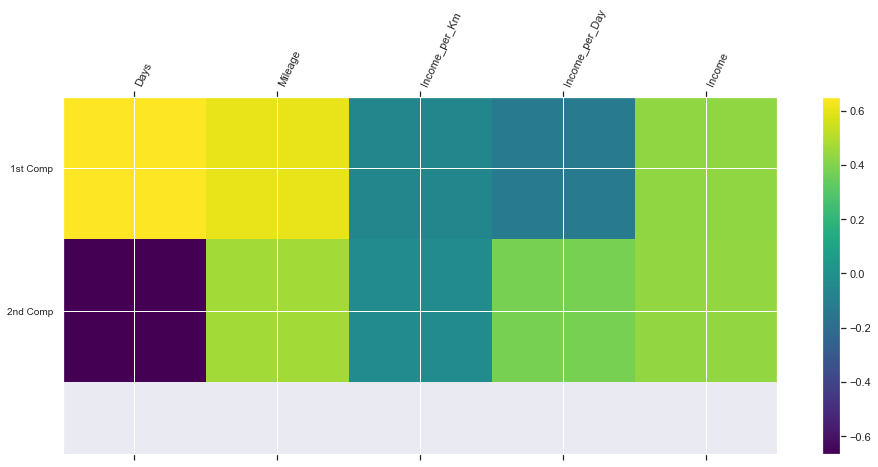

In [115]:
plt.matshow(pca.components_,cmap='viridis')
plt.yticks([0,1,2],['1st Comp','2nd Comp'],fontsize=10)
plt.colorbar()
plt.xticks(range(len(columns_for_pca.columns)),columns_for_pca.columns,rotation=65,ha='left')
plt.show()

In [116]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])
principalDf

,pc1,pc2
0,0.875755,-0.053799
1,0.820319,-0.106923
2,0.759751,-0.184678
3,0.640812,-0.271990
4,0.779854,-0.167093
...,...,...
172767,-0.368744,0.302533
172768,-0.371393,0.290589
172769,-0.365474,0.317235
172770,-0.368080,0.305526


### Таблица результатов PCA

In [117]:
pcs = df_norm[['id','Route','Regions','PostCodes']].join(principalDf)
pcs.tail()

,id,Route,Regions,PostCodes,pc1,pc2
172767,78377,DE-DE,BENELUX-BENELUX,DE41 - DE44,-0.368744,0.302533
172768,55487,CZ-CZ,CentralEurope-CentralEurope,CZ10 - CZ25,-0.371393,0.290589
172769,26160,GB-DE,UK-Denmark,GBRM - DE34,-0.365474,0.317235
172770,100881,FR-FR,BENELUX-BENELUX,FR59 - FR59,-0.368080,0.305526
172771,37449,DE-IT,CentralEurope-Italy,DE67 - IT24,-0.368046,0.305678


#### Нормирование главных компонент

In [118]:
pcs['pc1_norm'] = scaler.fit_transform(pcs[['pc1']].values)
pcs['pc2_norm'] = scaler.fit_transform(pcs[['pc2']].values)
pcs.head()

,id,Route,Regions,PostCodes,pc1,pc2,pc1_norm,pc2_norm
0,145267,IT-BG,Italy-Balkans / Turkey,IT20 - BG13,0.875755,-0.053799,0.923680,0.409359
1,9101,NO-DK,Norway (South)-Denmark,NO80 - DK58,0.820319,-0.106923,0.890401,0.373104
2,146616,LV-BE,Baltics-BENELUX,LVLV - BE08,0.759751,-0.184678,0.854042,0.320039
3,164863,AT-DE,CentralEurope-BENELUX,AT50 - DE29,0.640812,-0.271990,0.782643,0.260451
4,95808,LV-IT,Baltics-Italy,LVLV - IT48,0.779854,-0.167093,0.866110,0.332040


In [119]:
pcs.tail()

,id,Route,Regions,PostCodes,pc1,pc2,pc1_norm,pc2_norm
172767,78377,DE-DE,BENELUX-BENELUX,DE41 - DE44,-0.368744,0.302533,0.176606,0.652543
172768,55487,CZ-CZ,CentralEurope-CentralEurope,CZ10 - CZ25,-0.371393,0.290589,0.175016,0.644392
172769,26160,GB-DE,UK-Denmark,GBRM - DE34,-0.365474,0.317235,0.178569,0.662577
172770,100881,FR-FR,BENELUX-BENELUX,FR59 - FR59,-0.368080,0.305526,0.177005,0.654586
172771,37449,DE-IT,CentralEurope-Italy,DE67 - IT24,-0.368046,0.305678,0.177025,0.654690


## Routes Results
Таблица результатов по маршрутам

In [123]:
pcs.groupby(pcs.Route, as_index=False)['pc1_norm'].mean()

,Route,pc1_norm
0,AT-AT,0.429773
1,AT-BE,0.527916
2,AT-BG,0.748679
3,AT-CH,0.533066
4,AT-CZ,0.303635
...,...,...
504,SK-PL,0.332428
505,SK-SE,0.688994
506,TR-CH,0.903182
507,TR-DE,0.561825


In [124]:
res_routes = pcs.groupby(pcs.Route, as_index=False)['pc1_norm'].mean()
res_routes.head()

,Route,pc1_norm
0,AT-AT,0.429773
1,AT-BE,0.527916
2,AT-BG,0.748679
3,AT-CH,0.533066
4,AT-CZ,0.303635


Отсортированная таблица рейтинга маршрутов по методике PCA

In [125]:
res_routes = res_routes.sort_values(by='pc1_norm', ascending=False)
res_routes

,Route,pc1_norm
176,ES-EE,0.985969
49,BG-FR,0.959575
180,ES-GR,0.952939
408,NO-CH,0.949705
329,LU-BG,0.938626
...,...,...
187,ES-NO,0.216634
177,ES-ES,0.196379
88,CZ-CZ,0.188621
138,DK-DK,0.176374


In [ ]:
res_routes.head(15)

In [126]:
res_routes.to_csv(r'C:\Users\Julia\Notebooks (Py)\ds\rating_PCA_routes.csv', index = False)

По результатам видно, что как правило невыгодными являются маршруты внутри стран (HU-HU, DK-DK, CZ-CZ, ES-ES). Самым выгодным оказался маршурт достаточно продолжительный маршрут ES-EE.

## Regions Results

Таблица результатов по регионам

In [127]:
pcs.groupby(pcs.Regions, as_index=False)['pc1_norm'].mean()

,Regions,pc1_norm
0,#NAME?,0.326257
1,BENELUX-,0.805662
2,BENELUX-BENELUX,0.238977
3,BENELUX-Balkans / Turkey,0.850885
4,BENELUX-Baltics,0.777817
...,...,...
175,UK-Poland,0.876790
176,UK-South France,0.381056
177,UK-Spain,0.724856
178,UK-UK,0.245183


In [128]:
res_regions = pcs.groupby(pcs.Regions, as_index=False)['pc1_norm'].mean()
res_regions.head()

,Regions,pc1_norm
0,#NAME?,0.326257
1,BENELUX-,0.805662
2,BENELUX-BENELUX,0.238977
3,BENELUX-Balkans / Turkey,0.850885
4,BENELUX-Baltics,0.777817


Отсортированная таблица рейтинга регионов по методике PCA

In [129]:
res_regions = res_regions.sort_values(by='pc1_norm', ascending=False)
res_regions

,Regions,pc1_norm
143,Spain-Baltics,0.985969
22,Balkans / Turkey-North France,0.959575
146,Spain-Greece,0.952939
93,North France-Greece,0.950279
56,Denmark-Greece,0.942817
...,...,...
123,Poland-Poland,0.242199
2,BENELUX-BENELUX,0.238977
80,Italy-Italy,0.233401
149,Spain-Norway (South),0.216634


In [ ]:
res_regions.head(15)

In [130]:
res_regions.to_csv(r'C:\Users\Julia\Notebooks (Py)\ds\rating_PCA_regions.csv', index = False)

По результатам рейтинга по регионам внезапно оказалось, что маршруты по Греции достаточно выгодные. Также как и с маршрутами, поездки внутри региона не являются выгодными (Spain-Spain, Italy-Italy, BENELUX-BENELUX, Poland-Poland).

## PostCodes Results

Таблица результатов по почтовым кодам

In [131]:
pcs.groupby(pcs.PostCodes, as_index=False)['pc1_norm'].mean()

,PostCodes,pc1_norm
0,AT - AT,0.465660
1,AT - BE,0.460284
2,AT - CH,0.544216
3,AT - DE,0.416522
4,AT - DK,0.521859
...,...,...
18241,SK93 - SE25,0.632566
18242,SK96 - SE12,0.858278
18243,TR13 - DE30,0.561825
18244,TR13 - IT24,0.377793


In [132]:
res_postcodes = pcs.groupby(pcs.PostCodes, as_index=False)['pc1_norm'].mean()
res_postcodes.head()

,PostCodes,pc1_norm
0,AT - AT,0.465660
1,AT - BE,0.460284
2,AT - CH,0.544216
3,AT - DE,0.416522
4,AT - DK,0.521859


Отсортированная таблица рейтинга почтовых кодов по методике PCA

In [134]:
res_postcodes = res_postcodes.sort_values(by='pc1_norm', ascending=False)
res_postcodes

,PostCodes,pc1_norm
7075,FR - GR,1.000000
6892,ES30 - EE48,0.985969
2757,DE29 - GR19,0.982159
2873,DE31 - GRGR,0.978503
7943,FR62 - GR35,0.975001
...,...,...
9137,GBTW - GBMK,0.043011
8710,GBDE - GBS4,0.042809
251,BE20 - BE20,0.039365
9144,GBTW - GBUB,0.038971


In [135]:
res_postcodes.to_csv(r'C:\Users\Julia\Notebooks (Py)\ds\rating_PCA_postcodes.csv', index = False)

Аналогично, как в рейтинге по регионам, рейтинг по почтовым кодам показал, что нужно выбирать маршруты в Грецию, которые оказались в топе (FR-GR, DE-GR). Как уже показали два предыдущих рейтинга - не стоит выбирать маршруты внутри страны (региона).

## Data Envelopment Analysis (DEA)

DEA позволяет оценить эффективность маршрутов на основе входных и выходных переменных.

#### Input:
1. Mileage
2. Days

#### Output:
1. Income

Для данного рейтинга рассчитаем количество поездок по каждому маршруту и уберем поездки, которые были 1 раз за период.

In [136]:
dea_input = df_norm[['Days','Mileage']]
dea_input.head()

,Days,Mileage
0,1.000000,0.891009
1,0.999938,0.847907
2,0.999872,0.886489
3,0.999745,0.677462
4,0.999681,0.910973


In [137]:
dea_output = df_norm[['Income']]
dea_output.head()

,Income
0,0.830226
1,0.760504
2,0.555746
3,0.580533
4,0.568274


In [138]:
dea_input_routes =  df_norm.groupby(df_norm.Route, as_index=False).mean().loc[:,['Route','Days','Mileage']]
dea_input_routes.head()

,Route,Days,Mileage
0,AT-AT,0.475339,0.398229
1,AT-BE,0.469483,0.590089
2,AT-BG,0.791443,0.748452
3,AT-CH,0.539449,0.520889
4,AT-CZ,0.298183,0.306090


In [139]:
# Count of Routes 
df_routecounts = df_norm.Route.value_counts().rename_axis('Route').reset_index(name='RouteCounts')
df_routecounts.head()

,Route,RouteCounts
0,DE-DE,30442
1,NL-DE,9101
2,DE-NL,6776
3,DE-FR,5571
4,SE-NO,5253


In [140]:
# Merge two data frames
dea_input_routes = dea_input_routes.merge(df_routecounts, on='Route')
dea_input_routes.head()

,Route,Days,Mileage,RouteCounts
0,AT-AT,0.475339,0.398229,17
1,AT-BE,0.469483,0.590089,12
2,AT-BG,0.791443,0.748452,1
3,AT-CH,0.539449,0.520889,13
4,AT-CZ,0.298183,0.306090,35


In [141]:
dea_input_routes[['Days','Mileage']] = dea_input_routes[['Days','Mileage']]
# Remove routes with counts==1
dea_input_routes = dea_input_routes[dea_input_routes.RouteCounts>1]
dea_input_routes = dea_input_routes.reset_index()
dea_input_routes = dea_input_routes.iloc[:,dea_input_routes.columns!='index']
dea_input_routes.to_csv(r'C:\Users\Julia\Notebooks (Py)\ds\dea_input_routes.csv', index = False)
dea_input_routes.head()

,Route,Days,Mileage,RouteCounts
0,AT-AT,0.475339,0.398229,17
1,AT-BE,0.469483,0.590089,12
2,AT-CH,0.539449,0.520889,13
3,AT-CZ,0.298183,0.306090,35
4,AT-DE,0.275248,0.506062,311


In [142]:
# Add RouteCounts column
dea_output_routes = df_norm.groupby(df_norm.Route, as_index=False)['Income'].mean()
dea_output_routes = dea_output_routes.merge(df_routecounts, on='Route')

# Remove routes with counts==1
dea_output_routes = dea_output_routes[dea_output_routes.RouteCounts>1]
dea_output_routes = dea_output_routes.reset_index()
dea_output_routes = dea_output_routes.iloc[:,dea_output_routes.columns!='index']
# Remove RouteCouns column
dea_output_routes = dea_output_routes.iloc[:,dea_output_routes.columns!='RouteCounts']

dea_output_routes.to_csv(r'C:\Users\Julia\Notebooks (Py)\ds\dea_output_routes.csv', index = False)
dea_output_routes.head()

,Route,Income
0,AT-AT,0.414944
1,AT-BE,0.535158
2,AT-CH,0.548626
3,AT-CZ,0.336714
4,AT-DE,0.467322


Поскольку в Python не реализован метод DEA, импортируем пакеты из R

In [143]:
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import r
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [144]:
r_utils = importr('utils')
r_Benchmarking = importr('Benchmarking')
r_ggplot2 = importr('ggplot2')

In [145]:
#help(r_Benchmarking)

In [146]:
dea_input_routes[['Days','Mileage','RouteCounts']]

,Days,Mileage,RouteCounts
0,0.475339,0.398229,17
1,0.469483,0.590089,12
2,0.539449,0.520889,13
3,0.298183,0.306090,35
4,0.275248,0.506062,311
...,...,...,...
408,0.552580,0.673286,11
409,0.278074,0.401857,263
410,0.628679,0.728896,4
411,0.897041,0.907593,2


 Строим модель без учета масштаба, ориентированную на выход

In [147]:
resdm1 = np.array(r_Benchmarking.dea(dea_input_routes[['Days','Mileage']], dea_output_routes[['Income']], SLACK=True , 
                            RTS="VRS", ORIENTATION="OUT"))
resdm1[0][:10]

array([1.54235906, 1.4294996 , 1.42975296, 1.50427636, 1.21808905,
       1.36421071, 1.24237974, 1.42863522, 1.14703744, 1.17450274])

In [148]:
resdm1 = pd.DataFrame({"eff":resdm1[0]})
resdm1.head()

,eff
0,1.542359
1,1.429500
2,1.429753
3,1.504276
4,1.218089


In [149]:
dea_res = pd.concat([dea_input_routes[['Route']], resdm1[['eff']]], axis=1)

In [150]:
dea_res = dea_res.sort_values("eff", ascending=True)
dea_res.head()

,Route,eff
63,CZ-CZ,1.0
201,GR-LT,1.0
235,IT-FI,1.0
342,NO-GB,1.0
322,NL-IE,1.0


Добавляем количество поездок в итоговый рейтинг для удобства

In [151]:
dea_res.merge(df_routecounts, on='Route')

,Route,eff,RouteCounts
0,CZ-CZ,1.000000,273
1,GR-LT,1.000000,3
2,IT-FI,1.000000,74
3,NO-GB,1.000000,369
4,NL-IE,1.000000,7
...,...,...,...
408,NL-LI,2.012379,9
409,LT-LV,2.056451,145
410,LV-LT,2.097096,295
411,EE-LV,2.212941,1188


In [ ]:
dea_res.head(15)

In [152]:
dea_res.to_csv(r'C:\Users\Julia\Notebooks (Py)\ds\rating_DEA_routes.csv', index = False)

### DEA frontier
<!--<img src="Rplot03.png" width=800/>-->
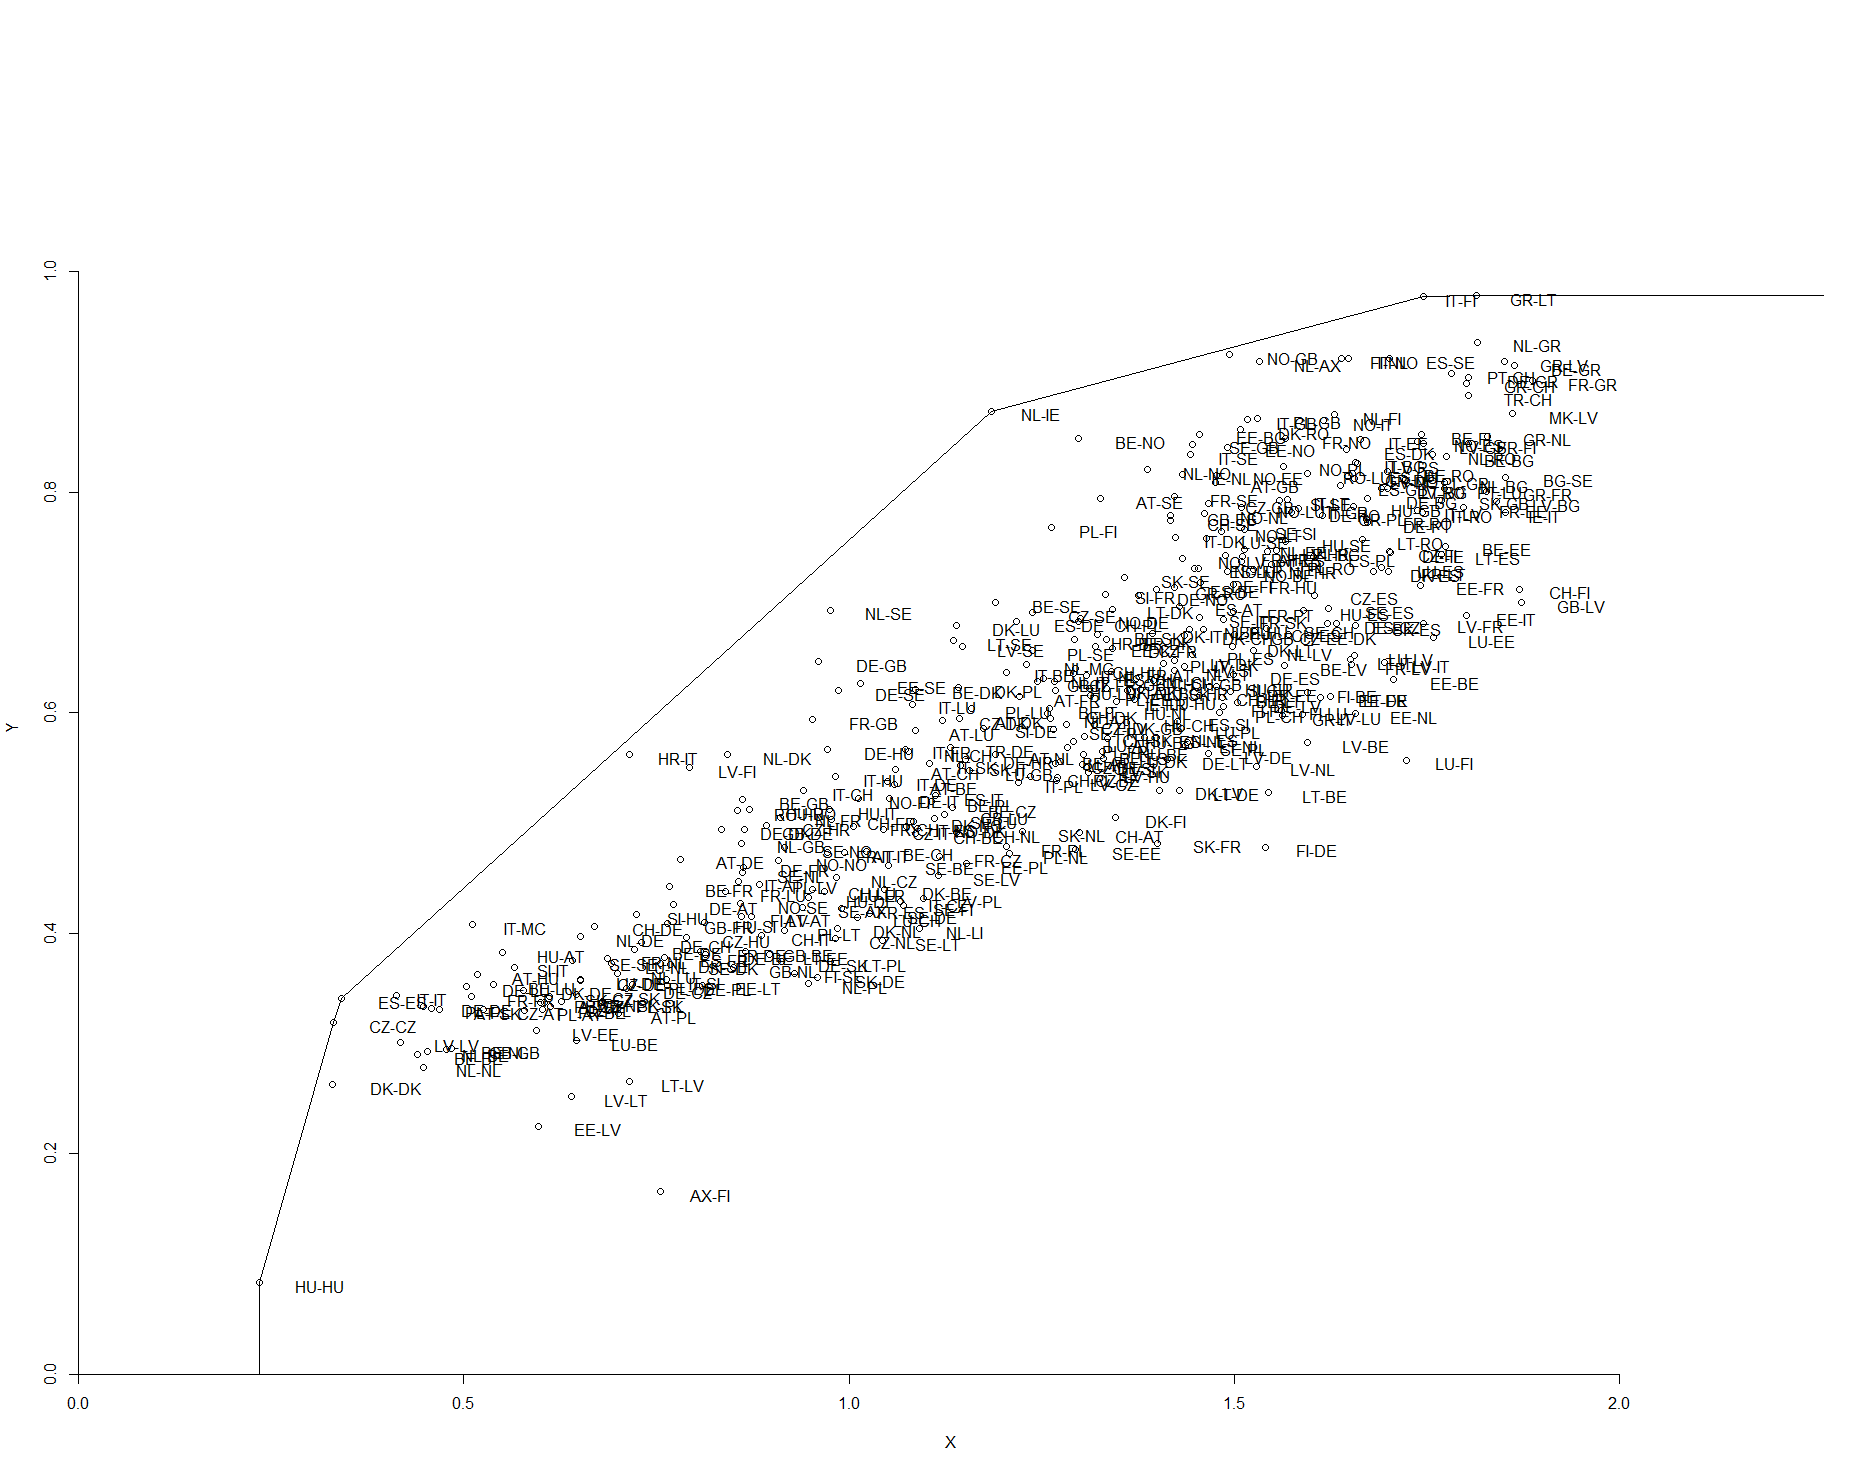

По рейтингу эффективности маршрутов лучшими оказались наоброт маршруты внутри страны, поскольку как правило такие маршруты короче по продолжительности и расстоянию, и в некоторых случаях выше по стоимости.
Неэффективными оказались маршруты LT-LV, LV-LT, очевидно минимальные по входным данным, но также невысокие и по выходным, что и сделало их неэффективными. Также, стоит отметить, что в рейтинг, в отличие от PCA, не включены маршруты с одной поездкой за весь период. Т.к. вряд ли мы выберем этот маршрут даже если он самый эффективный.

## Дополнительно

Разработка модели, при помощи которой можно рассчитать доход от поездки.
На основе пробега, дней, типа прицепа

In [153]:
# Split into 70% training and 30% testing set # ,'Ref','Canvas'
X_train, X_test, y_train, y_test = train_test_split(df_sc[['Days','Mileage','Ref','Canvas']], # 'TrailerType'
                                                    pd.Series(df_sc['Income']), 
                                        test_size = 0.3, 
                                        random_state = 42)

In [154]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

baseline_guess = np.median(y_train)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 23.10
Baseline Performance on the test set: MAE = 7.2185


### Выбор модели по наименьшей MAE

In [155]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

### Линейная регрессия

In [156]:
from sklearn.linear_model import LinearRegression
# Create the model
lr = LinearRegression()
# Fit and evaluate the model 
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 4.2781


### Случайный лес (Random Forest)

In [157]:
from sklearn.ensemble import RandomForestRegressor
# Create the model
random_forest = RandomForestRegressor(random_state=60)
# Fit and evaluate the model 
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 2.9787


### Градиентный бустинг

In [158]:
from sklearn.ensemble import GradientBoostingRegressor
# Create the model
gradient_boosted = GradientBoostingRegressor(random_state=60)
# Fit and evaluate the model 
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 3.1953


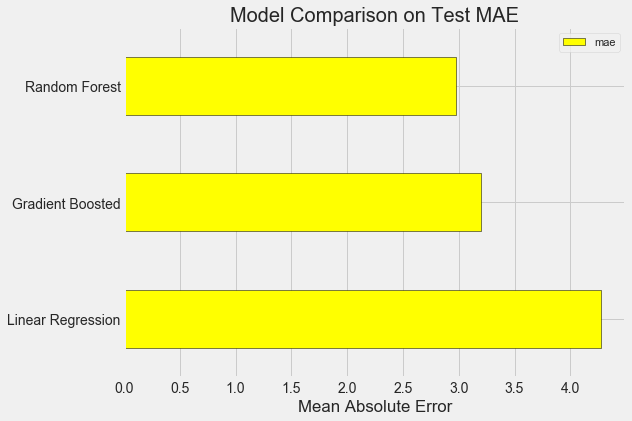

In [159]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 
                                           'Random Forest', 'Gradient Boosted'
                                          ],
                                 'mae': [lr_mae, random_forest_mae, 
                                         gradient_boosted_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = 'yellow', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20);

### Random Forest

In [165]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (120940, 4)
Training Labels Shape: (120940,)
Testing Features Shape: (51832, 4)
Testing Labels Shape: (51832,)


In [167]:
# Function to calculate mean absolute error
def mae(y_true, y_test):
    return np.mean(abs(y_true - y_test))

baseline_guess = np.median(y_train)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of 23.10
Baseline Performance on the test set: MAE = 7.2185


In [169]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [170]:
#rf_new = RandomForestRegressor(n_estimators = 100, criterion = 'mse', max_depth = None, 
#                               min_samples_split = 2, min_samples_leaf = 1)

## Make Predictions on Test Data

In [172]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


Mean Absolute Error: 2.97 degrees.


In [174]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 86.81 %.
